# Event Card Bonus
There are event cards that increase odds that an endeavor will be successful. For the "plus 1" event, major success count as two successes. We'll need to account for two outcomes in each combination: major successes and blanks. The formula for computing these odds is a bit trickier since a major success will cancel out a blank roll.

A simulation will be used to sample the probability space and be used as a sanity check to verify the formula.

In [1]:
%matplotlib inline

import itertools
import matplotlib
import matplotlib.pyplot
import numpy
import pandas
import scipy.misc
import scipy.special
import scipy.stats
import seaborn

In [2]:
# colormap for data visualizations
cmap = seaborn.cubehelix_palette(n_colors = 20, start = 0.8, rot = 0.75,
                                gamma = 0.3, hue = 2.0, dark = 0.005,
                                light = 0.95, reverse = True, as_cmap = True)

# The simulation


In [3]:
p_blank = 1.0/3
p_major = 1.0/6

def simulate_roll(total_dice):
    x = numpy.random.uniform(size=total_dice)
    conds = [x <= p_blank, (x > p_blank) & (x <= p_blank + p_major), (x > p_blank + p_major)]
    # each blank counts as 0, a major success counts as 2, and a regular success counts as 1
    roll_array = numpy.piecewise(x, conds, [0, 2, 1])
    return numpy.sum(roll_array)

def success_roll_simulator(total_dice, n):
    sim_list = [simulate_roll(total_dice) for i in range(n)]
    return numpy.array(sim_list)

In [4]:
n = 10000
success_count_list = [success_roll_simulator(i, n) for i in numpy.arange(1,31)]
for i, array in enumerate(success_count_list):
    array[array < 0] = 0
    success_count_list[i] = array
success_count_itemfreq = [scipy.stats.itemfreq(a) for a in success_count_list]

In [5]:
len(success_count_itemfreq)

30

In [6]:
# sdp_sim will give the probability of a specific instance occuring.
# the rows are the size of the dice pool
# the columns are the specific number of blanks after accounting for major successes
sdp_sim = numpy.zeros((30,61))
for i, array in enumerate(success_count_itemfreq):
    for j in array:
        sdp_sim[i, j[0].astype(int)] = j[1]/n

In [7]:
row_success = numpy.arange(0,61) # number of dice showing the blank face
col_dice = numpy.arange(1,31) # number of dice in the pool
sdp_sim_dataframe = pandas.DataFrame(data = sdp_sim, index = col_dice, columns = row_success)
sdp_sim_dataframe_stack = sdp_sim_dataframe.stack().reset_index().rename(
    columns = {
        "level_0" : "number_success", 
        "level_1" : "number_dice_pool", 
        0 : "probability_number_success"})
sdp_sim_mask = numpy.triu(numpy.ones((15,16)), 2)
sdp_sim_pivot = sdp_sim_dataframe_stack.pivot("number_success", 
                                              "number_dice_pool", 
                                              "probability_number_success")

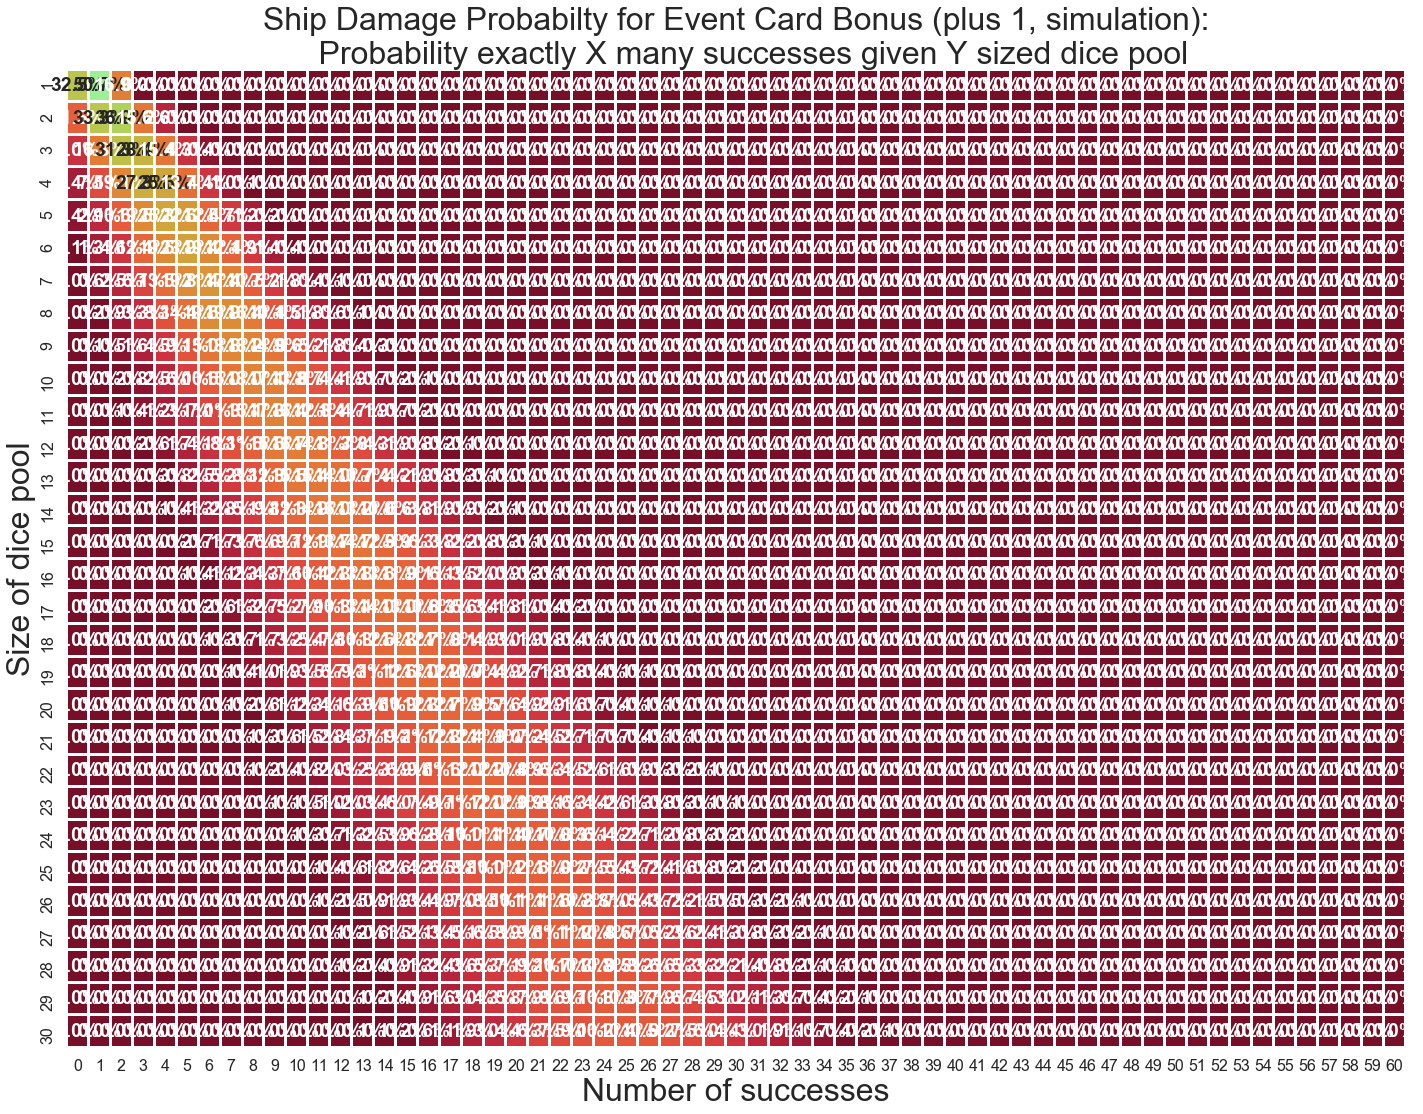

In [8]:
#mask = sdp_sim_mask

seaborn.set(style = "white")
seaborn.set_context("poster")
matplotlib.pyplot.figure(figsize=(24, 18))
ax = seaborn.heatmap(sdp_sim_pivot, annot = True, cmap = cmap,
                     cbar = False, annot_kws = {"weight" : "extra bold"},
                     fmt = ".1%", linewidths = 2, vmin=0.0, 
                     vmax=1.0)
ax.set_title(
    """Ship Damage Probabilty for Event Card Bonus (plus 1, simulation):
    Probability exactly X many successes given Y sized dice pool""",
    fontsize=32)
ax.set_xlabel("Number of successes", fontsize=32)
ax.set_ylabel("Size of dice pool", fontsize=32)
fig = ax.get_figure()
fig.savefig("ship_damage_probabilities_exact_1to15_plus1_simulation.pdf")
fig.savefig("ship_damage_probabilities_exact_1to15_plus1_simulation.svg", format="svg", dpi=1200)

In [9]:
# for the greater than or equal probabilites, sum along the rows
sdp_sim_gte = numpy.zeros((30,40))
for (i, j), _ in numpy.ndenumerate(sdp_sim_gte):
    sdp_sim_gte[i, j] = numpy.sum(sdp_sim[i, j+1:])

In [10]:
col_success = numpy.arange(1,41) # number of dice showing the blank face
row_dice = numpy.arange(1,31) # number of dice in the pool
sdp_sim_gte_dataframe = pandas.DataFrame(data = sdp_sim_gte, index = row_dice, columns = col_success)
sdp_sim_gte_dataframe_stack = sdp_sim_gte_dataframe.stack().reset_index().rename(
    columns = {
        "level_0" : "number_success", 
        "level_1" : "number_dice_pool", 
        0 : "probability_GTE_to_number_success"})
sdp_sim_gte_mask = numpy.triu(numpy.ones((15,30)), 1)
sdp_sim_gte_pivot = sdp_sim_gte_dataframe_stack.pivot("number_success", 
                                                      "number_dice_pool", 
                                                      "probability_GTE_to_number_success")

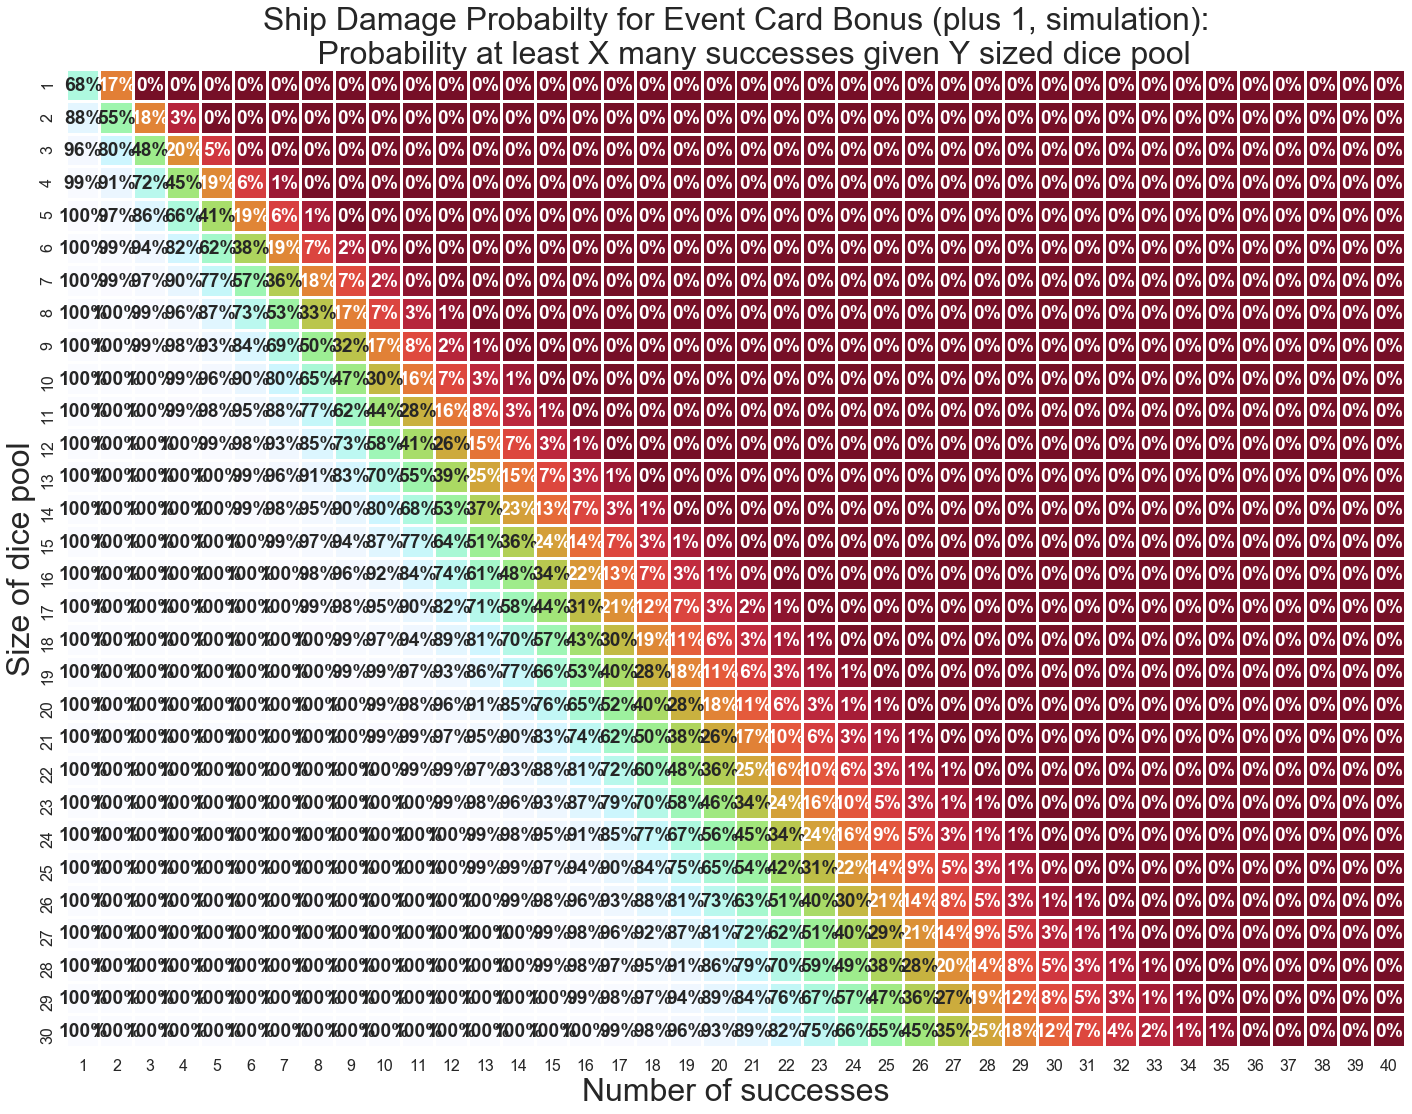

In [11]:
seaborn.set(style = "white")
seaborn.set_context("poster")
matplotlib.pyplot.figure(figsize=(24, 18))
ax = seaborn.heatmap(sdp_sim_gte_pivot, annot = True, cmap = cmap,
                     cbar = False, annot_kws = {"weight" : "extra bold"},
                     fmt = ".0%", linewidths = 2, vmin=0.0, 
                     vmax=1.0)
ax.set_title(
    """Ship Damage Probabilty for Event Card Bonus (plus 1, simulation):
    Probability at least X many successes given Y sized dice pool""",
    fontsize=32)
ax.set_xlabel("Number of successes", fontsize=32)
ax.set_ylabel("Size of dice pool", fontsize=32)
fig = ax.get_figure()
fig.savefig("ship_damage_probabilities_1to15_plus1_simulation.pdf")
fig.savefig("ship_damage_probabilities_1to15_plus1_simulation.svg", format="svg", dpi=1200)

# The formula
The odds for major successes are $1/6$. The key to calculating the number of outcomes is the [Multinomial Coefficient](https://en.wikipedia.org/wiki/Multinomial_theorem). 

In [12]:
p_blank = 1.0/3
p_major = 1.0/6

def prob_success_and_major(num_success, num_major, total_dice):
    if num_success + num_major > total_dice:
        p = 0.0
    else:    
        # https://en.wikipedia.org/wiki/Multiset#Counting_multisets
        p = (p_blank)**(total_dice-num_success-num_major) * \
        (p_major)**num_major * \
        (1-p_blank-p_major)**num_success * \
        scipy.misc.factorial(total_dice) / \
        (scipy.misc.factorial(num_success) * \
         scipy.misc.factorial(num_major) * \
         scipy.misc.factorial(total_dice - num_success - num_major)) 
    return p

def prob_success(num_success, total_dice):
    if total_dice < numpy.ceil(num_success/2.0):
        
        p = 0.0
        
    else:
        
        rng_success = numpy.arange(0, total_dice + 1)
        
        array_prob = []
        
        # x + 2y = n, x = success, y = major success, n = total number of successes
        for i in rng_success:
            
            x = i
            
            if num_success < x:
            
                array_prob.append(0.0)
                
                continue
            
            y = num_success - x
            
            if y % 2 == 0:
                
                y = y/2.0
                
                array_prob.append(prob_success_and_major(x, y, total_dice))
                
            else:
                
                array_prob.append(0.0)
            
        p = numpy.sum(array_prob)
        
    return p 

def prob_success_or_better(num_success, total_dice):
    if total_dice < numpy.ceil(num_success/2.0):
        p = 0.0
    else:
        rng_success = numpy.arange(num_success, 2*total_dice + 1)
        array_success = [prob_success(i, total_dice) for i in rng_success]
        p = numpy.sum(array_success)
    return p

In [13]:
p_blank = 1.0/3
p_major = 1.0/6

def prob_blank_and_major(num_blank, num_major, total_dice):
    if num_blank + num_major > total_dice:
        p = 0.0
    else:    
        # https://en.wikipedia.org/wiki/Multiset#Counting_multisets
        p = (p_blank)**num_blank * \
        (p_major)**num_major * \
        (1-p_blank-p_major)**(total_dice-num_blank-num_major) * \
        scipy.misc.factorial(total_dice) / \
        (scipy.misc.factorial(num_blank) * \
         scipy.misc.factorial(num_major) * \
         scipy.misc.factorial(total_dice - num_blank - num_major)) 
    return p

def prob_blank(num_blank, total_dice):
    if total_dice < num_blank:
        p = 0.0
    else:
        rng_blank = numpy.arange(num_blank, total_dice + 1)
        array_blank_and_major = [prob_blank_and_major(i, i-num_blank, total_dice) for i in numpy.arange(num_blank, 1 + numpy.floor((total_dice + num_blank)/2))]
        p = numpy.sum(array_blank_and_major)
    return p 

def prob_blank_or_worse(num_blank, total_dice):
    if total_dice < num_blank:
        p = 0.0
    else:
        rng_blank = numpy.arange(num_blank, total_dice + 1)
        array_blank = [prob_blank(i, total_dice) for i in rng_blank]
        p = numpy.sum(array_blank)
    return p

In [14]:
row_success = numpy.arange(1,22) # number successes in a dice pool
col_dice = numpy.arange(1,16) # number of dice in the pool
sdp = numpy.zeros((numpy.size(row_success),numpy.size(col_dice)))
prob = [prob_success_or_better(*i) for i in itertools.product(row_success, col_dice)]
ind = [tuple(numpy.subtract(i,1)) for i in itertools.product(row_success, col_dice)]
for idx, val in enumerate(ind):
    sdp[val] = prob[idx]
sdp_dataframe = pandas.DataFrame(data = sdp, index = row_success, columns = col_dice)
sdp_dataframe_stack = sdp_dataframe.stack().reset_index().rename(
    columns = {
        "level_0" : "number_success", 
        "level_1" : "number_dice_pool", 
        0 : "probability_GTE_to_number_success"})
#sdp_mask = numpy.triu(numpy.ones((15,15)), 1)
sdp_pivot = sdp_dataframe_stack.pivot("number_dice_pool", 
                                      "number_success", 
                                      "probability_GTE_to_number_success")
sdp_mask = sdp_pivot < 0.001
sdp_mask = sdp_mask.as_matrix()

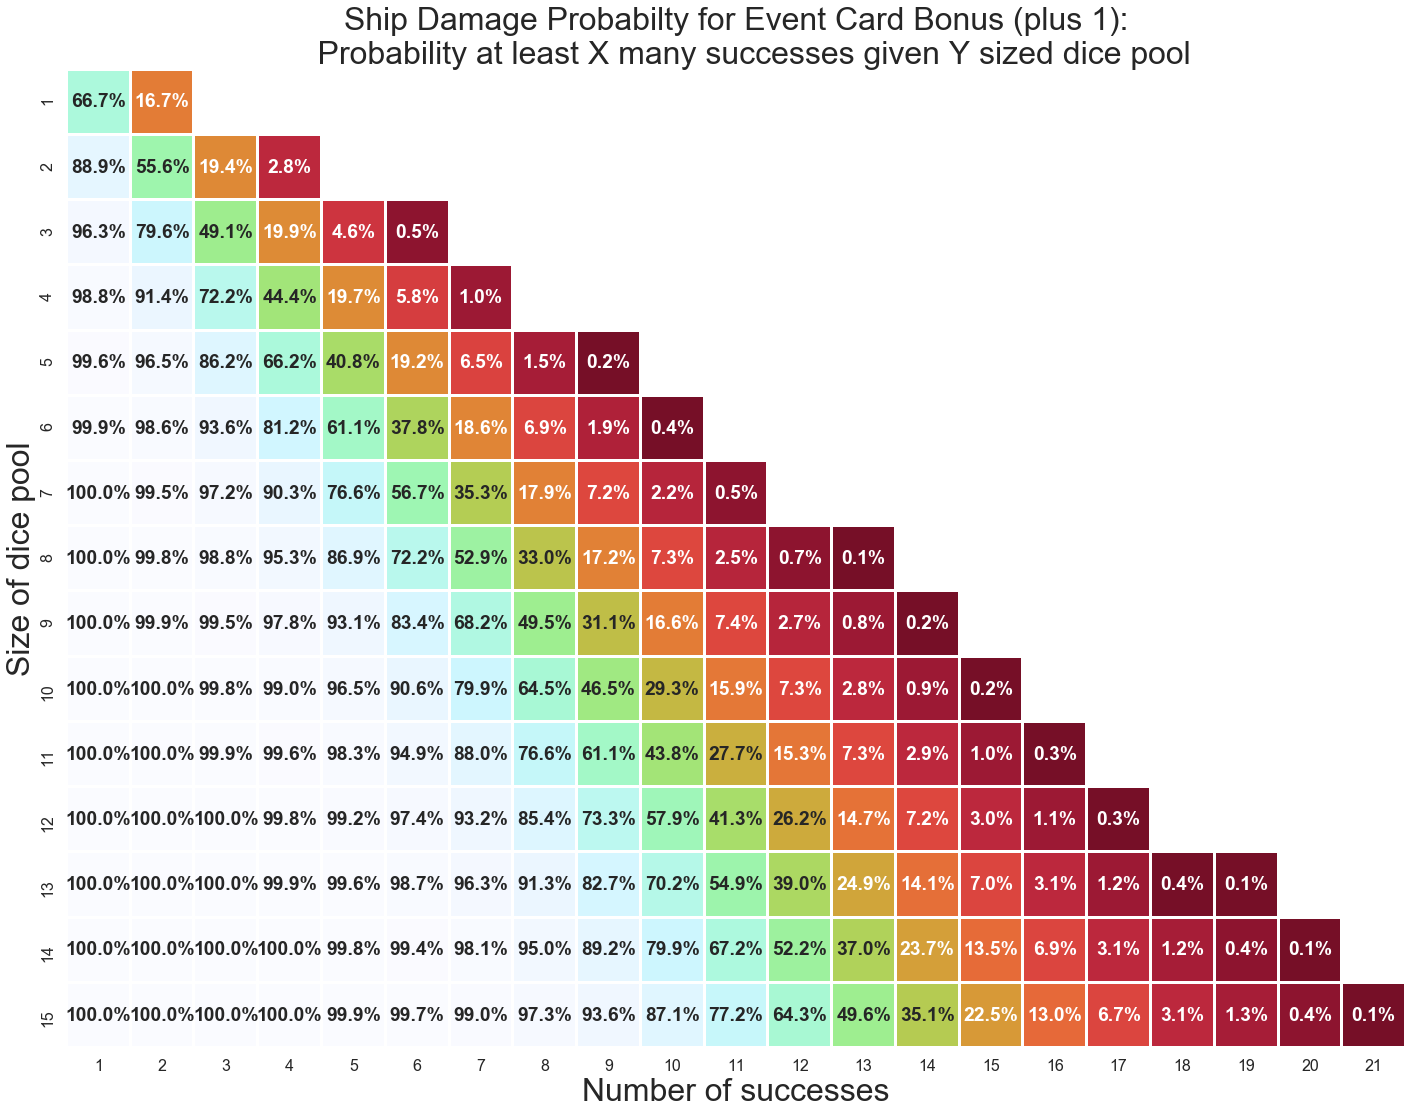

In [15]:
seaborn.set(style = "white")
seaborn.set_context("poster")
matplotlib.pyplot.figure(figsize=(24, 18))
ax = seaborn.heatmap(sdp_pivot, annot = True, cmap = cmap,
                     cbar = False, mask = sdp_mask, annot_kws = {"weight" : "extra bold"},
                     fmt = ".1%", linewidths = 2, vmin=0.0, 
                     vmax=1.0)
ax.set_title(
    """Ship Damage Probabilty for Event Card Bonus (plus 1):
    Probability at least X many successes given Y sized dice pool""",
    fontsize=32)
ax.set_xlabel("Number of successes", fontsize=32)
ax.set_ylabel("Size of dice pool", fontsize=32)
fig = ax.get_figure()
fig.savefig("ship_damage_probabilities_1to15_plus1.pdf")
fig.savefig("ship_damage_probabilities_1to15_plus1.svg", format="svg", dpi=1200)

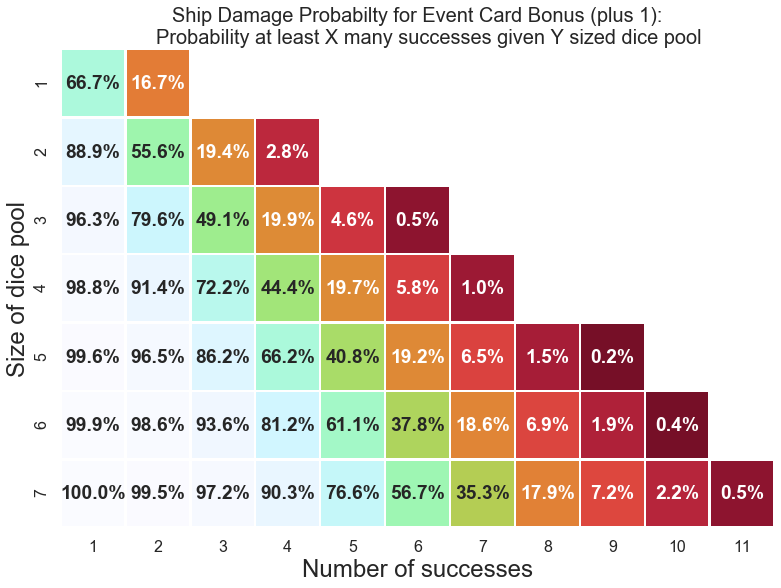

In [16]:
sdp_dataframe_7 = sdp_dataframe_stack.loc[(sdp_dataframe_stack["number_success"] < 12) & 
                                          (sdp_dataframe_stack["number_dice_pool"] < 8)]


sdp_pivot_7 = sdp_dataframe_7.pivot("number_dice_pool", 
                                    "number_success", 
                                    "probability_GTE_to_number_success")

sdp_mask_7 = sdp_pivot_7 < 0.001
sdp_mask_7 = sdp_mask_7.as_matrix()

ax2 = seaborn.heatmap(sdp_pivot_7, annot = True, cmap = cmap,
                     cbar = False, mask = sdp_mask_7, annot_kws = {"weight" : "extra bold"},
                     fmt = ".1%", linewidths = 1.5, vmin=0.0, 
                     vmax=1.0)
ax2.set_title(
    """Ship Damage Probabilty for Event Card Bonus (plus 1):
    Probability at least X many successes given Y sized dice pool""",
    fontsize=20)
ax2.set_xlabel("Number of successes", fontsize=24)
ax2.set_ylabel("Size of dice pool", fontsize=24)
fig = ax2.get_figure()
fig.savefig("ship_damage_probabilities_1to7_plus1.pdf")
fig.savefig("ship_damage_probabilities_1to7_plus1.svg", format="svg", dpi=1200)

In [17]:
p_major = 1.0/6

def prob_major(num_major, total_dice):
    if total_dice < num_major:
        p = 0.0
    else:
        p = (p_major)**num_major * \
        (1-p_major)**(total_dice-num_major) * \
        scipy.misc.comb(total_dice, total_dice - num_major)
    return p

def prob_major_or_better(num_major, total_dice):
    if total_dice < num_major:
        p = 0.0
    else:
        rng_major = numpy.arange(num_major, total_dice + 1)
        array_major = [prob_major(n, total_dice) for n in rng_major]
        p = numpy.sum(array_major)
    return p

In [18]:
row_major = numpy.arange(1,16) # number of dice showing the major success face
col_dice = numpy.arange(1,16) # number of dice in the pool
sdp_major = numpy.zeros((numpy.size(row_major),numpy.size(col_dice)))
prob = [prob_major_or_better(*i) for i in itertools.product(row_major, col_dice)]
ind = [tuple(numpy.subtract(i,1)) for i in itertools.product(row_major, col_dice)]
for idx, val in enumerate(ind):
    sdp_major[val] = prob[idx]
sdp_major_dataframe = pandas.DataFrame(data = sdp_major, index = row_major, columns = col_dice)
sdp_major_dataframe_stack = sdp_major_dataframe.stack().reset_index().rename(
    columns = {
        "level_0" : "number_major", 
        "level_1" : "number_dice_pool", 
        0 : "probability_GTE_to_number_major"})
sdp_major_mask = numpy.triu(numpy.ones((15,15)), 1)
sdp_major_pivot = sdp_major_dataframe_stack.pivot("number_dice_pool", 
                                                  "number_major", 
                                                  "probability_GTE_to_number_major")

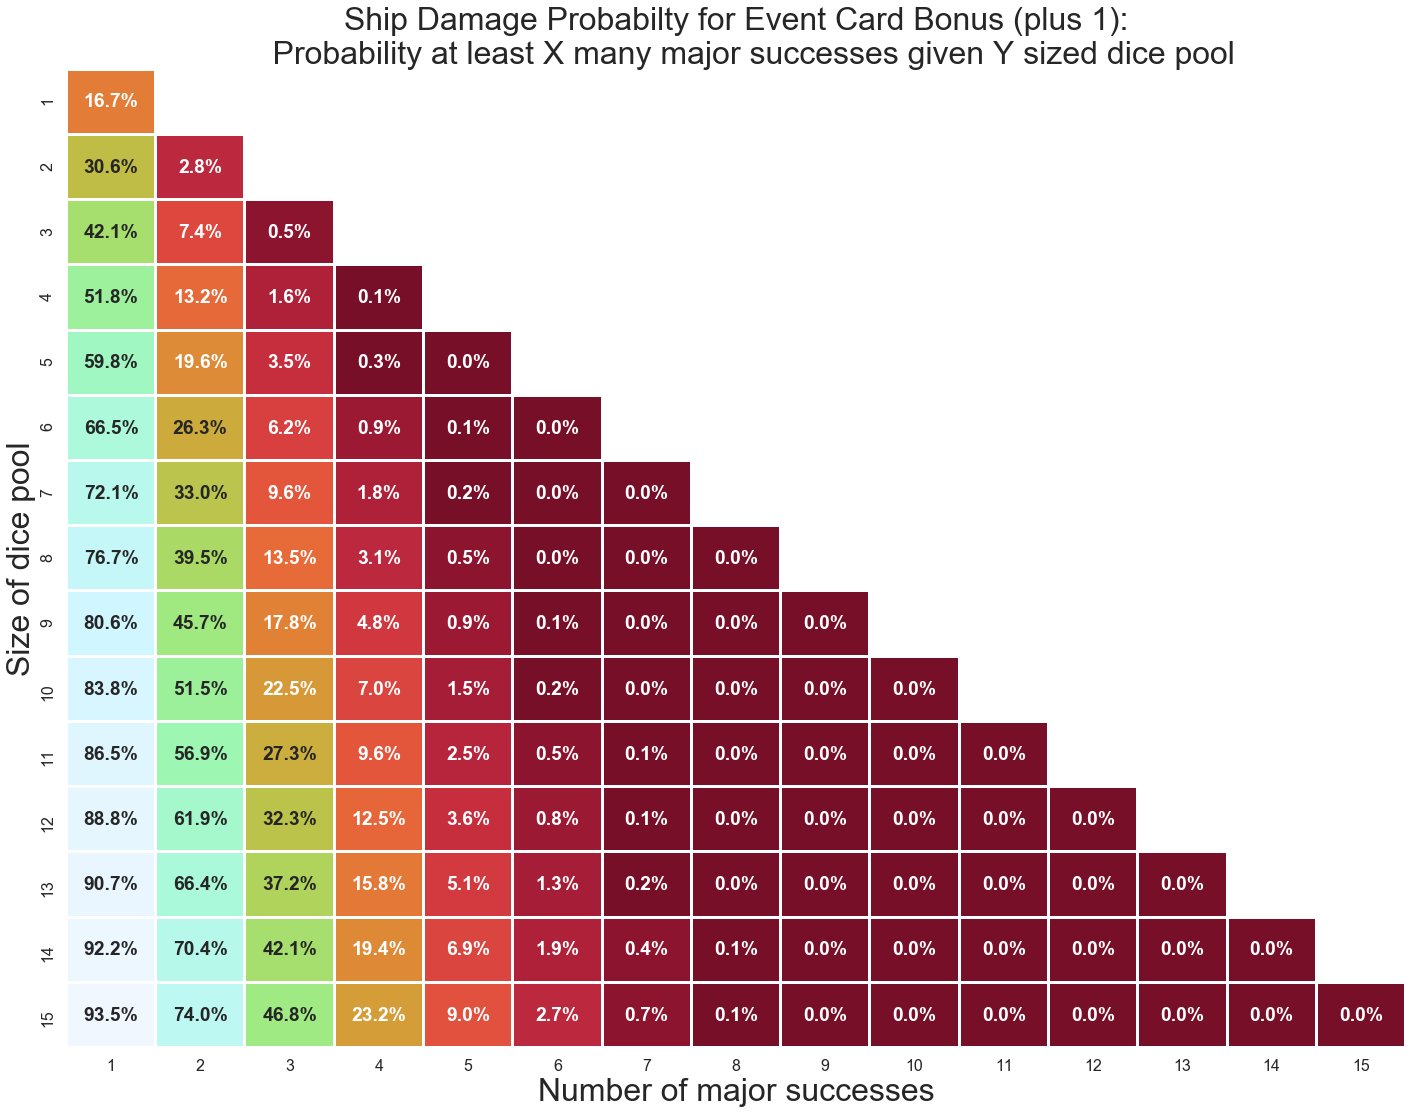

In [19]:
seaborn.set(style = "white")
seaborn.set_context("poster")
matplotlib.pyplot.figure(figsize=(24, 18))
ax = seaborn.heatmap(sdp_major_pivot, annot = True, cmap = cmap,
                     cbar = False, mask = sdp_major_mask, annot_kws = {"weight" : "extra bold"},
                     fmt = ".1%", linewidths = 2, vmin=0.0, 
                     vmax=1.0)
ax.set_title(
    """Ship Damage Probabilty for Event Card Bonus (plus 1):
    Probability at least X many major successes given Y sized dice pool""",
    fontsize=32)
ax.set_xlabel("Number of major successes", fontsize=32)
ax.set_ylabel("Size of dice pool", fontsize=32)
fig = ax.get_figure()
fig.savefig("major_successes_1to15.pdf")
fig.savefig("major_successes_1to15.svg", format="svg", dpi=1200)

## Back to Tahiti
Previously, we calculated that the probability of rolling a blank increased from $0.\overline{3}$ to $0.4$. Now that major successes are meaningful, and could also result from re-rolling and minor success, we must update the probability of this result as well. The major success probability can be calculated by modifying our previous result:

\begin{equation} \frac{1}{6} \sum_{k=0}^\infty \left(\frac{1}{6}\right)^k \Rightarrow \frac{1}{6} \cdot \frac{1}{1 - \frac{1}{6}} = 0.2 \end{equation}

Interestingly, it is now clear how the probabilities change due to re-rolling minor successes. Instead of solving a geometric series we could have inferred that re-rolling minor successes is akin to removing the face of the die, changing a 6-sided die into a 5-sided die. Then computing the fractions of the dice faces would yield all the probabilities, just like they did for the first calculations we made with 6-sided dice.

In [20]:
p_blank = 0.4
p_major = 0.2

def prob_success_and_major(num_success, num_major, total_dice):
    if num_success + num_major > total_dice:
        p = 0.0
    else:    
        # https://en.wikipedia.org/wiki/Multiset#Counting_multisets
        p = (p_blank)**(total_dice-num_success-num_major) * \
        (p_major)**num_major * \
        (1-p_blank-p_major)**num_success * \
        scipy.misc.factorial(total_dice) / \
        (scipy.misc.factorial(num_success) * \
         scipy.misc.factorial(num_major) * \
         scipy.misc.factorial(total_dice - num_success - num_major)) 
    return p

def prob_success(num_success, total_dice):
    if total_dice < numpy.ceil(num_success/2.0):
        
        p = 0.0
        
    else:
        
        rng_success = numpy.arange(0, total_dice + 1)
        
        array_prob = []
        
        # x + 2y = n, x = success, y = major success, n = total number of successes
        for i in rng_success:
            
            x = i
            
            if num_success < x:
            
                array_prob.append(0.0)
                
                continue
            
            y = num_success - x
            
            if y % 2 == 0:
                
                y = y/2.0
                
                array_prob.append(prob_success_and_major(x, y, total_dice))
                
            else:
                
                array_prob.append(0.0)
            
        p = numpy.sum(array_prob)
        
    return p 

def prob_success_or_better(num_success, total_dice):
    if total_dice < numpy.ceil(num_success/2.0):
        p = 0.0
    else:
        rng_success = numpy.arange(num_success, 2*total_dice + 1)
        array_success = [prob_success(i, total_dice) for i in rng_success]
        p = numpy.sum(array_success)
    return p

In [21]:
row_success = numpy.arange(1,22) # number of successes in the pool
col_dice = numpy.arange(1,16) # number of dice in the pool
sdp_i3 = numpy.zeros((numpy.size(row_success),numpy.size(col_dice)))
prob = [prob_success_or_better(*i) for i in itertools.product(row_success, col_dice)]
ind = [tuple(numpy.subtract(i,1)) for i in itertools.product(row_success, col_dice)]
for idx, val in enumerate(ind):
    sdp_i3[val] = prob[idx]
sdp_i3_dataframe = pandas.DataFrame(data = sdp_i3, index = row_success, columns = col_dice)
sdp_i3_dataframe_stack = sdp_i3_dataframe.stack().reset_index().rename(
    columns = {
        "level_0" : "number_success", 
        "level_1" : "number_dice_pool", 
        0 : "probability_GTE_to_number_success"})

sdp_i3_pivot = sdp_i3_dataframe_stack.pivot("number_dice_pool", 
                                      "number_success", 
                                      "probability_GTE_to_number_success")

sdp_i3_mask = sdp_i3_pivot < 0.001
sdp_i3_mask = sdp_i3_mask.as_matrix()

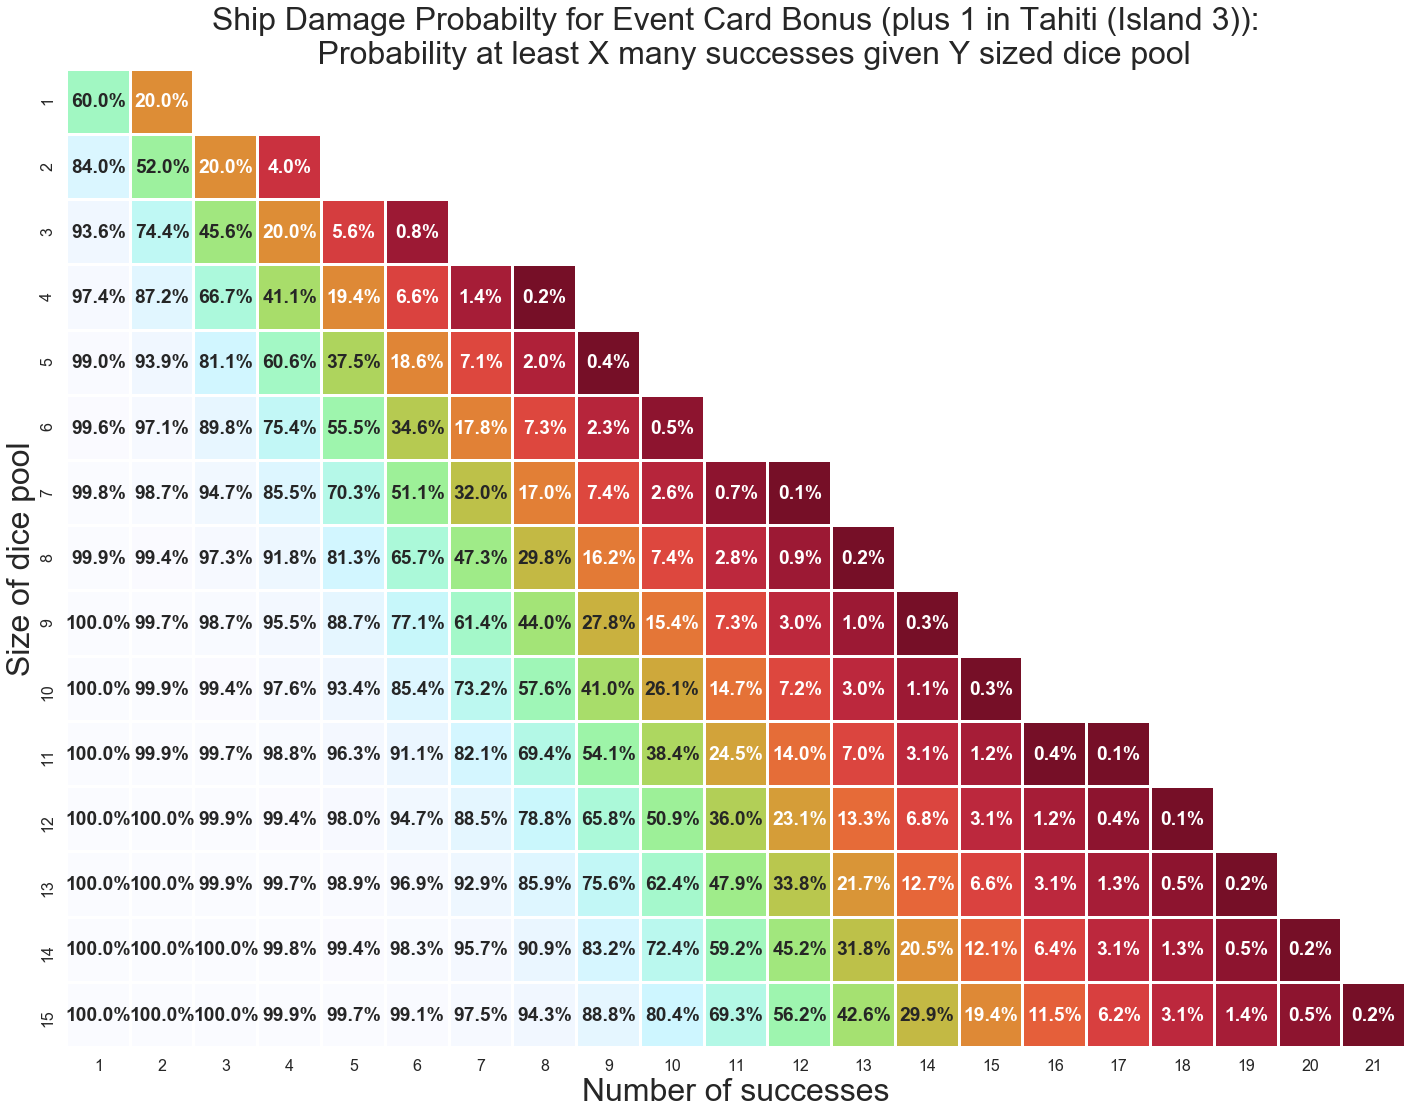

In [22]:
seaborn.set(style = "white")
seaborn.set_context("poster")
matplotlib.pyplot.figure(figsize=(24, 18))
ax = seaborn.heatmap(sdp_i3_pivot, annot = True, cmap = cmap,
                     cbar = False, mask = sdp_i3_mask, annot_kws = {"weight" : "extra bold"},
                     fmt = ".1%", linewidths = 2, vmin=0.0, 
                     vmax=1.0)
ax.set_title(
    """Ship Damage Probabilty for Event Card Bonus (plus 1 in Tahiti (Island 3)):
    Probability at least X many successes given Y sized dice pool""",
    fontsize=32)
ax.set_xlabel("Number of successes", fontsize=32)
ax.set_ylabel("Size of dice pool", fontsize=32)
fig = ax.get_figure()
fig.savefig("ship_damage_probabilities_1to15_plus1_island3.pdf")
fig.savefig("ship_damage_probabilities_1to15_plus1_island3.svg", format="svg", dpi=1200)